In [1]:
!pip install torch
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# # installing easily via pip
!pip install -q 'git+https://github.com/sarah-keren/multi-taxi'
!pip install -q 'git+https://github.com/sarah-keren/MAC'

     |████████████████████████████████| 631 kB 7.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59.6 MB 69.8 MB/s 
     |████████████████████████████████| 54.5 MB 1.1 MB/s 
     |████████████████████████████████| 1.0 MB 47.2 MB/s 
     |████████████████████████████████| 244 kB 51.8 MB/s 
     |████████████████████████████████| 53.2 MB 120 kB/s 
     |████████████████████████████████| 53.2 MB 126 kB/s 
     |████████████████████████████████| 52.7 MB 60 kB/s 
     |████████████████████████████████| 52.7 MB 78 kB/s 
     |████████████████████████████████| 125 kB 52.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires pro

## Before First Run Do The Following (only for colab)

1. Create a `tmp` directory in the main `content` directory.
2. Create a `src` directory in the main `content` directory.
3. Copy all `.py` files from the local `src` directory to the one created in __colab__.

Now you are ready to run your own experiment. After running an experiment you will find a new dictionery in the `tmp` directory with its name being the date-time of the experiment. Inside the experiment directory you can find:
- learning curve plot
- evaluation curve plot
- a logger with the experiment's info (parameters and such)
- the network saved during the experiment

Good Luck !!!

In [3]:
import os
import sys
import torch as T
import numpy as np
import random
import time
import logging
from pathlib import Path
from datetime import datetime
from mac.environments.env_wrapper import EnvWrappperMultiTaxi
from multi_taxi import MultiTaxiEnv
from src.utils_controller import (DecentralizedRlController, CentralizedRlController,
                                  create_decentralized_agent, create_centralized_agent)
from src.utils import plot_multi_taxi_learning_curve
sys.path.append("./src")

# seeding everything for experimental reproducibility
SEED = 42
np.random.seed(SEED)    # numpy
T.manual_seed(SEED)     # torch
random.seed(SEED)       # random

simple_MAP = [
    "+---------+",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "| : : : : |",
    "+---------+",
]

MAP = [
    "+-----------------------+",
    "| : |F: | : | : | : |F: |",
    "| : | : : : | : | : | : |",
    "| : : : : : : : : : : : |",
    "| : : : : : | : : : : : |",
    "| : : : : : | : : : : : |",
    "| : : : : : : : : : : : |",
    "| | :G| | | :G| | | : | |",
    "+-----------------------+",
]


In [11]:
load_agent = False
train = True
evaluate = True
base_dir = './tmp'
directory_to_load = '2022_06_11__23_37_09'

# directory of experiment
now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
experiment_directory = now if not load_agent else directory_to_load

# if False run Centralized control, else run Decentralized control
decentralized_control_simulation = False

# multi_taxi parameters
num_taxis = 2
num_passengers = 2
can_see_others = False
domain_map = simple_MAP
pickup_only = True

# DQN parameters
kwargs = {
    'gamma': 0.99,
    'epsilon': 1,
    'lr': 1e-4,
    'mem_size': 100000,
    'batch_size': 32,
    'eps_min': 0.01,
    'eps_dec': 2e-5,
    'replace': 4000,
    'algo': 'dqn',
    'env_name': 'multi_taxi'
}

# controller parameters
max_iteration = 100
max_episode = 10000

# create unique directory for saving
kwargs['chkpt_dir'] = base_dir
kwargs['chkpt_dir'] = os.path.join(kwargs['chkpt_dir'], experiment_directory)

# set up the experiment directory for saving
if not load_agent:
    Path(kwargs['chkpt_dir']).mkdir(parents=True, exist_ok=True)

# set up a logger
logging.basicConfig(filemode='a')
log = logging.getLogger()
log.setLevel(logging.INFO)
fh = logging.FileHandler(filename=os.path.join(kwargs['chkpt_dir'], 'experiment_log.log'))
fh.setLevel(logging.INFO)
formatter = logging.Formatter(fmt='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
fh.setFormatter(formatter)
log.addHandler(fh)
log.info('-------------- Experiment Log ---------------')
log.info(f"SEED = {SEED}")
log.info(f"Controller: {'Decentralized' if decentralized_control_simulation else 'Centralized'}")
log.info("---- Environment parameters ----")
log.info(f"num_taxis = {num_taxis}")
log.info(f"num_passengers = {num_passengers}")
log.info(f"can_see_others = {can_see_others}")
log.info("domain_map = ")
for line in domain_map:
    log.info(f"{line}")
log.info(f"pickup_only = {pickup_only}")
log.info("---- RL algorithm parameters ----")
log.info(f"kwargs = {kwargs}")
log.info("---- Controller parameters ----")
log.info(f"load_agent = {load_agent}")
log.info(f"Path: {directory_to_load if load_agent else ''}")
log.info(f"evaluate = {evaluate}")
log.info(f"train = {train}")
log.info(f"max_iteration = {max_iteration}")
log.info(f"max_episode = {max_episode}")


INFO:root:-------------- Experiment Log ---------------
INFO:root:SEED = 42
INFO:root:Controller: Centralized
INFO:root:---- Environment parameters ----
INFO:root:num_taxis = 2
INFO:root:num_passengers = 2
INFO:root:can_see_others = False
INFO:root:domain_map = 
INFO:root:+---------+
INFO:root:| : : : : |
INFO:root:| : : : : |
INFO:root:| : : : : |
INFO:root:| : : : : |
INFO:root:| : : : : |
INFO:root:+---------+
INFO:root:pickup_only = True
INFO:root:---- RL algorithm parameters ----
INFO:root:kwargs = {'gamma': 0.99, 'epsilon': 1, 'lr': 0.0001, 'mem_size': 100000, 'batch_size': 32, 'eps_min': 0.01, 'eps_dec': 2e-05, 'replace': 4000, 'algo': 'dqn', 'env_name': 'multi_taxi', 'chkpt_dir': './tmp/2022_06_13__13_06_42'}
INFO:root:---- Controller parameters ----
INFO:root:load_agent = False
INFO:root:Path: 
INFO:root:evaluate = True
INFO:root:train = True
INFO:root:max_iteration = 100
INFO:root:max_episode = 10000


In [12]:
# set up the environment
taxi_env = MultiTaxiEnv(num_taxis=num_taxis, num_passengers=num_passengers, 
                        can_see_others=can_see_others,
                        domain_map=domain_map, pickup_only=pickup_only)

# wrap environment to be MAC compatible
taxi_env = EnvWrappperMultiTaxi(taxi_env)

# render
taxi_env.render()

+---------+
| : : : : |
| : : : : |
|P: : :_: |
| : :P: : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,3), Collided: False
Taxi1-RED: Fuel: inf, Location: (2,0), Collided: False
Passenger1: Location: (3, 2), Destination: pickup only!
Passenger2: Location: (2, 0), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]


100%|██████████| 10000/10000 [30:18<00:00,  5.50it/s]


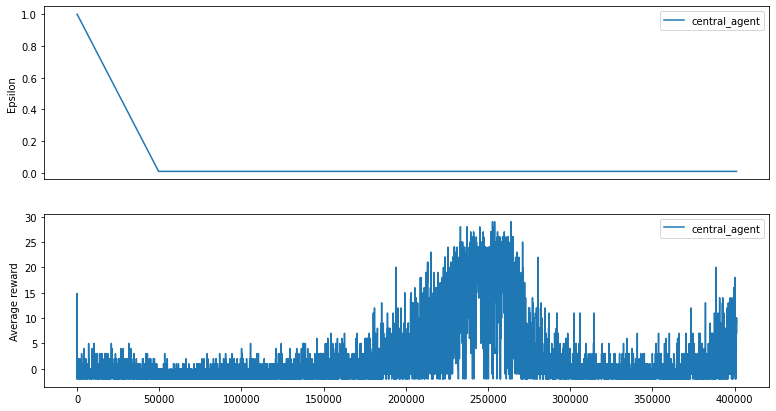

+---------+
|_: : : : |
| : : : : |
|_: : : : |
| : : :P: |
| : :P: : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (0,0), Collided: False
Taxi1-RED: Fuel: inf, Location: (2,0), Collided: False
Passenger1: Location: (3, 3), Destination: pickup only!
Passenger2: Location: (4, 2), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+---------+
| : : : : |
|_: : : : |
| : : : : |
|_: : :P: |
| : :P: : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,0), Collided: False
Taxi1-RED: Fuel: inf, Location: (3,0), Collided: False
Passenger1: Location: (3, 3), Destination: pickup only!
Passenger2: Location: (4, 2), Destination: pickup only!
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2, 2]
+---------+
| : : : : |
| :_: : : |
| : : : : |
| : : :P: |
|_: :P: : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (1,1), Collided: False
Taxi1-RED: Fuel: inf, Location: (4,0), Collided: Fal

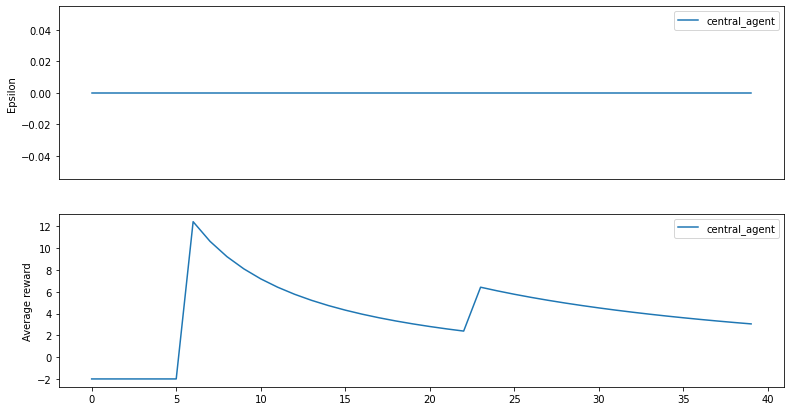

INFO:root:Total experiment time: 30.0 minutes
INFO:root:-------------- Experiment Done --------------


In [13]:
start_time = time.time()
# set up and run the controller
if decentralized_control_simulation:
    # set up a dictionary of RL decision makers, one for each taxi
    dqn_agents = {}
    for agent_id in taxi_env.get_env_agents():
        dqn_agents[agent_id] = create_decentralized_agent('dqn', taxi_env, agent_id, kwargs, load_agent)

    # initialize a decentralized controller
    decentralized_rl_controller = DecentralizedRlController(env=taxi_env, agents=dqn_agents)

    if train:
        # train
        total_rewards, agents_epsilons = decentralized_rl_controller.train(render=False,
                                                                            max_iteration=max_iteration,
                                                                            max_episode=max_episode)

        # plot training process results
        plot_multi_taxi_learning_curve(total_rewards, agents_epsilons,
                                        filename=os.path.join(kwargs['chkpt_dir'], 'learning_curve_' + now))

    if evaluate:
        # evaluate
        eval_total_rewards = decentralized_rl_controller.evaluate(render=True, max_iteration=20, max_episode=1)

        # plot evaluation process results
        plot_multi_taxi_learning_curve(eval_total_rewards,
                                        filename=os.path.join(kwargs['chkpt_dir'], 'evaluation_curve_' + now))

else:
    # set up a dictionary of a single decision makers, one for all taxi
    central_dqn_agent = {}
    agent_id = 'central_agent'
    central_dqn_agent[agent_id] = create_centralized_agent('dqn', taxi_env, agent_id, kwargs, load_agent)

    # initialize a centralized controller
    centralized_rl_controller = CentralizedRlController(env=taxi_env, central_agent=central_dqn_agent)

    if train:
        # train
        total_reward, agent_epsilon = centralized_rl_controller.train(render=False, max_iteration=max_iteration,
                                                                      max_episode=max_episode)

        # plot training process results
        plot_multi_taxi_learning_curve(total_reward, agent_epsilon,
                                        filename=os.path.join(kwargs['chkpt_dir'], 'learning_curve_' + now))

    if evaluate:
        # evaluate
        eval_total_rewards = centralized_rl_controller.evaluate(render=True, max_iteration=20, max_episode=2)

        # plot evaluation process results
        plot_multi_taxi_learning_curve(eval_total_rewards,
                                        filename=os.path.join(kwargs['chkpt_dir'], 'evaluation_curve_' + now))

# close logger
log.info(f"Total experiment time: {(time.time() - start_time) // 60} minutes")
log.info("-------------- Experiment Done --------------")
log.removeHandler(fh)
